# Analysis of Candidate Costimulatory Domains

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

import costim_screen as cs

## Define Paths to Data and Results

In [2]:
base_path = Path('/Users/cordessf/OneDrive/ACI/Repositories/CostimScreen')
data_path = base_path / 'data'
results_path = base_path / 'results'
results_path.mkdir(parents=True, exist_ok=True)

candidate_metadata_path = data_path / 'candidate_metadata.xlsx'
counts_path = data_path / 'merged_counts.xlsx'
elm_annotation_path = data_path / 'costim_normalized_elms_groupings.xlsx'
sample_metadata_path = data_path / 'sample_metadata.xlsx'
topology_metadata_path = data_path / 'costim_topol_protein_families.xlsx'

## Prepare Metadata

In [3]:
# Construct sample metadata from counts column names
smeta = cs.sample_metadata_from_counts_xlsx(
    counts_path,
    out_xlsx=sample_metadata_path,
    strict=True,
)

# Construct candidate metadata
cand = cs.merge_candidate_metadata(
    elm_annotation_path,
    topology_metadata_path,
    out_xlsx=candidate_metadata_path,
)

# ELM design matrix (with optional quadratic interactions)
X_elm = cs.build_elm_category_design(
    cand,
    include_quadratic=True,
    min_freq=0.01,
    min_interaction_freq=0.01,  # tweak if you want more/less aggressive interaction pruning
)

## Load Inputs

In [4]:
counts_wide = cs.load_counts_matrix(counts_path, candidate_id_col="CandidateID")
smeta = cs.load_sample_metadata(sample_metadata_path)
cand = cs.load_candidate_metadata(candidate_metadata_path)

# ---- Align IDs and columns
common_candidates = counts_wide.index.intersection(cand.index)
common_samples = counts_wide.columns.intersection(smeta.index)

counts_wide = counts_wide.loc[common_candidates, common_samples]
cand = cand.loc[common_candidates]
smeta = smeta.loc[common_samples]

## Filter Low-signal candidates

In [5]:
counts_wide = cs.filter_domains_by_total_counts(counts_wide, min_total=50)
cand = cand.loc[counts_wide.index]

## Build ELM design

In [6]:
X_elm = cs.build_elm_category_design(
    cand.reset_index(),
    candidate_id_col="CandidateID",
    elm_col="ELMCategory",
    include_quadratic=False,           # No pairwise interactions
    min_freq=0.025,                    # Require 10% frequency
)

# Make patsy-safe column names
safe_cols, mapping = cs.make_patsy_safe_columns(list(X_elm.columns), prefix="ELM_")
X_elm = X_elm.rename(columns=mapping)
pd.Series(mapping).to_csv(results_path / "elm_feature_name_map.csv")

print(f"Number of ELM features: {len(X_elm.columns)}")

# Restrict inferential analysis to non-GPCR
non_gpcr_ids = cand.index[cand["is_gpcr"] == 0]
counts_wide = counts_wide.loc[non_gpcr_ids]
X_elm = X_elm.loc[non_gpcr_ids]
cand = cand.loc[non_gpcr_ids]

# Sample-level derived variables
smeta = smeta.copy()
smeta.index.name = "sample_id"  # Ensure index name is preserved
smeta["phenotype"] = smeta["Tsubset"].astype(str) + "_" + smeta["PD1Status"].astype(str)
smeta["block"] = cs.make_block_id(smeta)

# Long table + offset
df = cs.counts_to_long(counts_wide, id_col="CandidateID")
df = df.merge(smeta.reset_index(), on="sample_id", how="left")
df = cs.add_library_size(df)

# Attach ELM features
df = df.merge(X_elm.reset_index().rename(columns={"index": "CandidateID"}), on="CandidateID", how="left")

# Drop incomplete rows
df = df.dropna(subset=["phenotype", "block", "offset", "count"])

# Let's look at what we have...
df

Number of ELM features: 35


,CandidateID,sample_id,count,Donor,ExpCond,Tsubset,PD1Status,Replicate,phenotype,block,...,SUMO,TRAF2like,TRAF4,TRAF6,TYR,UBA3,USP7,WD40,WRC,WW
0,ACKR1-1,1_Act CAR_CM_High_1,6147,1,Act CAR,CM,High,1,CM_High,1_Act CAR_r1,...,0,0,0,0,0,0,0,1,0,0
1,ACKR1-1,1_Act CAR_CM_High_2,3645,1,Act CAR,CM,High,2,CM_High,1_Act CAR_r2,...,0,0,0,0,0,0,0,1,0,0
2,ACKR1-1,1_Act CAR_CM_High_3,6901,1,Act CAR,CM,High,3,CM_High,1_Act CAR_r3,...,0,0,0,0,0,0,0,1,0,0
3,ACKR1-1,1_Act CAR_CM_Low_1,11547,1,Act CAR,CM,Low,1,CM_Low,1_Act CAR_r1,...,0,0,0,0,0,0,0,1,0,0
4,ACKR1-1,1_Act CAR_CM_Low_2,13711,1,Act CAR,CM,Low,2,CM_Low,1_Act CAR_r2,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142987,ZDHHC5-1,2_CAR_Naïve_High_2,0,2,CAR,Naïve,High,2,Naïve_High,2_CAR_r2,...,0,0,0,0,0,0,1,1,1,1
142988,ZDHHC5-1,2_CAR_Naïve_High_3,0,2,CAR,Naïve,High,3,Naïve_High,2_CAR_r3,...,0,0,0,0,0,0,1,1,1,1
142989,ZDHHC5-1,2_CAR_Naïve_Low_1,0,2,CAR,Naïve,Low,1,Naïve_Low,2_CAR_r1,...,0,0,0,0,0,0,1,1,1,1
142990,ZDHHC5-1,2_CAR_Naïve_Low_2,0,2,CAR,Naïve,Low,2,Naïve_Low,2_CAR_r2,...,0,0,0,0,0,0,1,1,1,1


# Analyze CAR:Raji

In [7]:
df_raji = df[df["ExpCond"] == "CAR:Raji"].copy()
df_raji["phenotype"] = pd.Categorical(df_raji["phenotype"])

motif_cols = [c for c in X_elm.columns]
formula = cs.build_joint_formula(motif_cols)

fit = cs.fit_nb_glm_iter_alpha(df_raji, formula=formula, offset_col="offset", cluster_col="block")

with open(results_path / "glm_summary.txt", "w") as f:
    f.write(str(fit.res.summary()))
(pd.Series({"alpha": fit.alpha})).to_csv(results_path / "alpha.csv")

print("Estimated alpha:", fit.alpha)

Estimated alpha: 1.1516655737502615


## Plot Volcano Plots

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'EM_High vs CM_High (Raji)  |  alpha=1.15'}, xlabel='$\\log_2$ fold change', ylabel='$-\\log_{10}$ q-value'>)

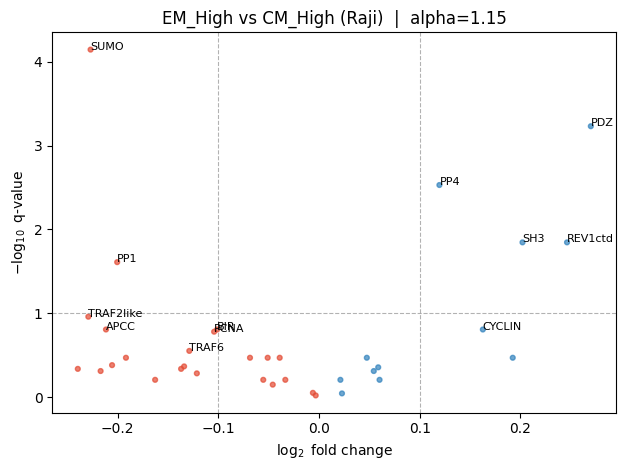

In [10]:
# Choose the contrast you want
p = "EM_High"
q = "CM_High"

res = cs.motif_contrast_table(
    fit,
    motifs=motif_cols,
    p=p,
    q=q,
    adjust="BH",
    log_base=2.0,
)

res.to_csv(results_path / f"volcano_table_{p}_vs_{q}.csv", index=False)

title = f"{p} vs {q} (Raji)  |  alpha={fit.alpha:.3g}"
cs.volcano_plot(
    res,
    q_thresh=0.10,
    lfc_thresh=0.10,
    title=title,
    top_n_labels=12,
    outpath=results_path / f"volcano_{p}_vs_{q}.png",
)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'EM_High vs EM_Low (Raji)  |  alpha=1.15'}, xlabel='$\\log_2$ fold change', ylabel='$-\\log_{10}$ q-value'>)

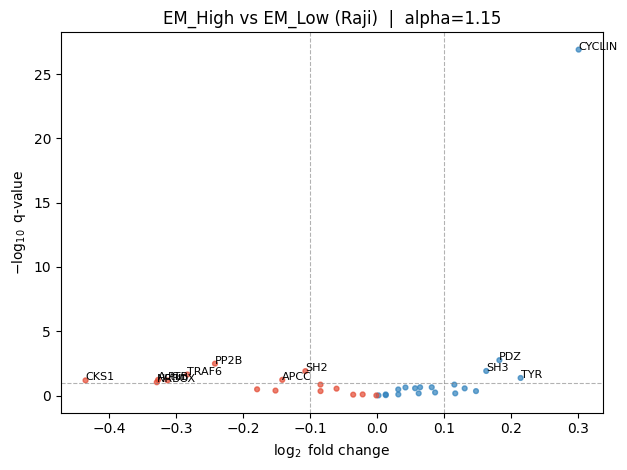

In [11]:
# Choose the contrast you want
p = "EM_High"
q = "EM_Low"

res = cs.motif_contrast_table(
    fit,
    motifs=motif_cols,
    p=p,
    q=q,
    adjust="BH",
    log_base=2.0,
)

res.to_csv(results_path / f"volcano_table_{p}_vs_{q}.csv", index=False)

title = f"{p} vs {q} (Raji)  |  alpha={fit.alpha:.3g}"
cs.volcano_plot(
    res,
    q_thresh=0.10,
    lfc_thresh=0.10,
    title=title,
    top_n_labels=12,
    outpath=results_path / f"volcano_{p}_vs_{q}.png",
)

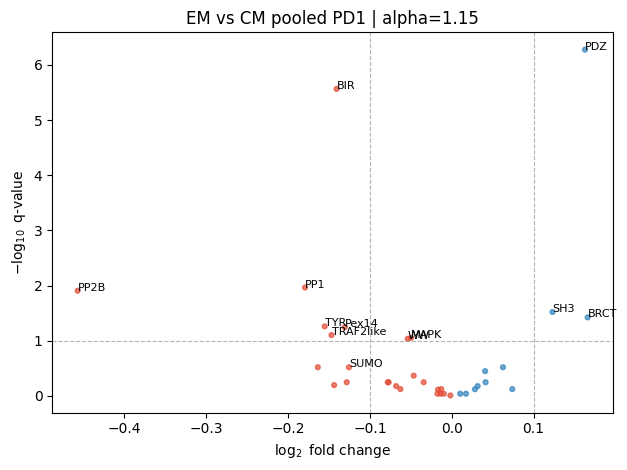

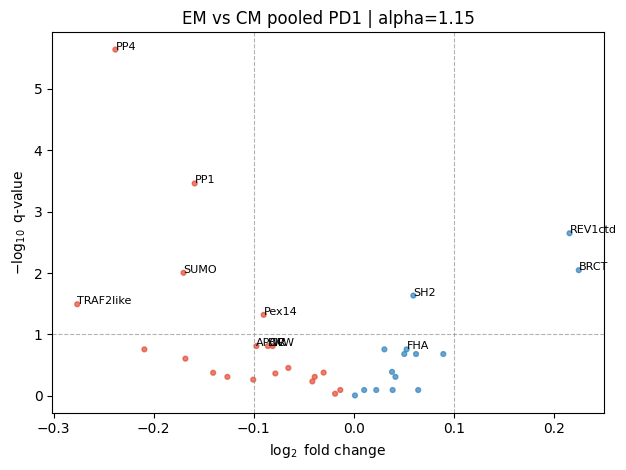

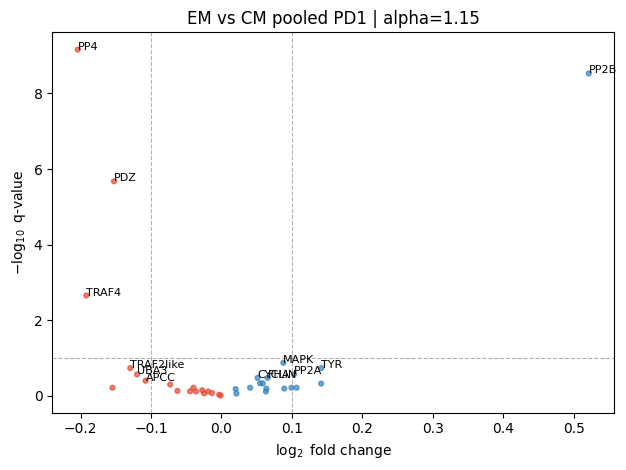

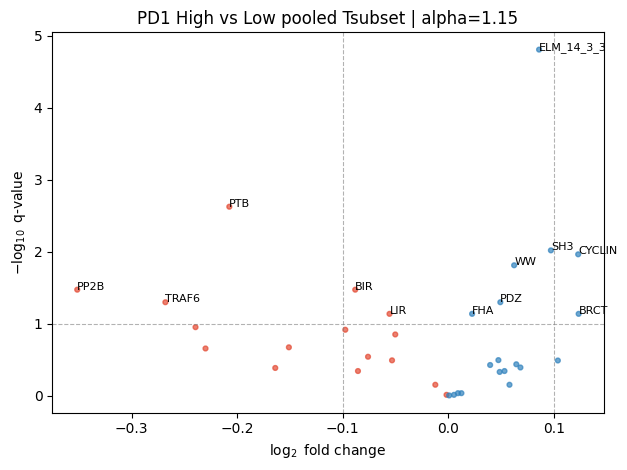

In [12]:
motifs = motif_cols  # your patsy-safe ELM features

# Tsubset comparisons pooled over PD1
# ... EM versus CM
tab_em_vs_cm = cs.volcano_tsubset_pooled_pd1(
    fit,
    motifs,
    tsubset_p="EM",
    tsubset_q="CM",
    q_thresh=0.10,
    lfc_thresh=0.1,
    title=f"EM vs CM pooled PD1 | alpha={fit.alpha:.3g}",
    outpath=results_path / "volcano_EM_vs_CM_pooledPD1.png",
)
tab_em_vs_cm.to_csv(results_path / "table_EM_vs_CM_pooledPD1.csv", index=False)

# ... EM versus Naive
tab_em_vs_cm = cs.volcano_tsubset_pooled_pd1(
    fit,
    motifs,
    tsubset_p="EM",
    tsubset_q="Naïve",
    q_thresh=0.10,
    lfc_thresh=0.1,
    title=f"EM vs CM pooled PD1 | alpha={fit.alpha:.3g}",
    outpath=results_path / "volcano_EM_vs_Naive_pooledPD1.png",
)
tab_em_vs_cm.to_csv(results_path / "table_EM_vs_Naive_pooledPD1.csv", index=False)

# ... CM versus Naive
tab_em_vs_cm = cs.volcano_tsubset_pooled_pd1(
    fit,
    motifs,
    tsubset_p="CM",
    tsubset_q="Naïve",
    q_thresh=0.10,
    lfc_thresh=0.1,
    title=f"EM vs CM pooled PD1 | alpha={fit.alpha:.3g}",
    outpath=results_path / "volcano_CM_vs_Naive_pooledPD1.png",
)
tab_em_vs_cm.to_csv(results_path / "table_CM_vs_Naive_pooledPD1.csv", index=False)

# PD1 comparisons pooled over Tsubset
tab_pd1 = cs.volcano_pd1_pooled_tsubset(
    fit,
    motifs,
    tsubsets=("Naïve", "CM", "EM"),
    pd1_high="High",
    pd1_low="Low",
    q_thresh=0.10,
    lfc_thresh=0.10,
    title=f"PD1 High vs Low pooled Tsubset | alpha={fit.alpha:.3g}",
    outpath=results_path / "volcano_PD1High_vs_PD1Low_pooledTsubset.png",
)
tab_pd1.to_csv(results_path / "table_PD1High_vs_PD1Low_pooledTsubset.csv", index=False)

# Plot Pooled Heatmap

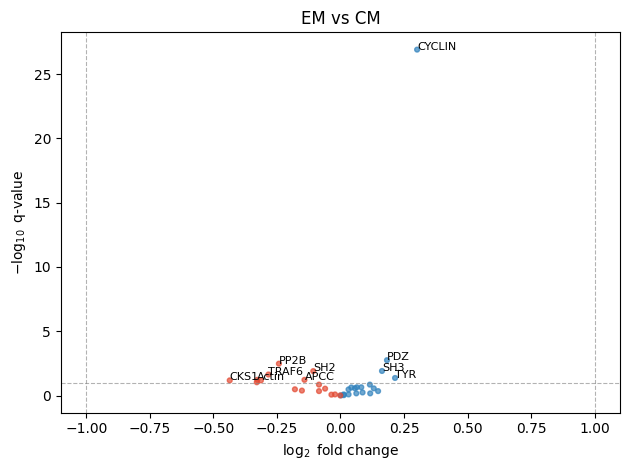

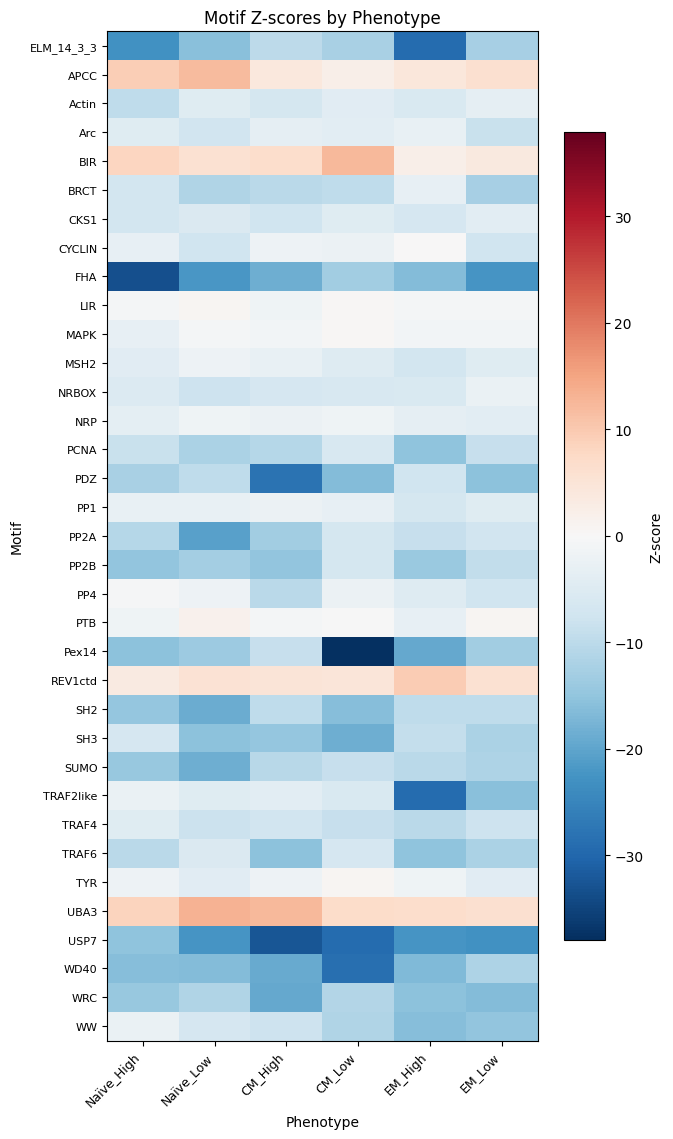

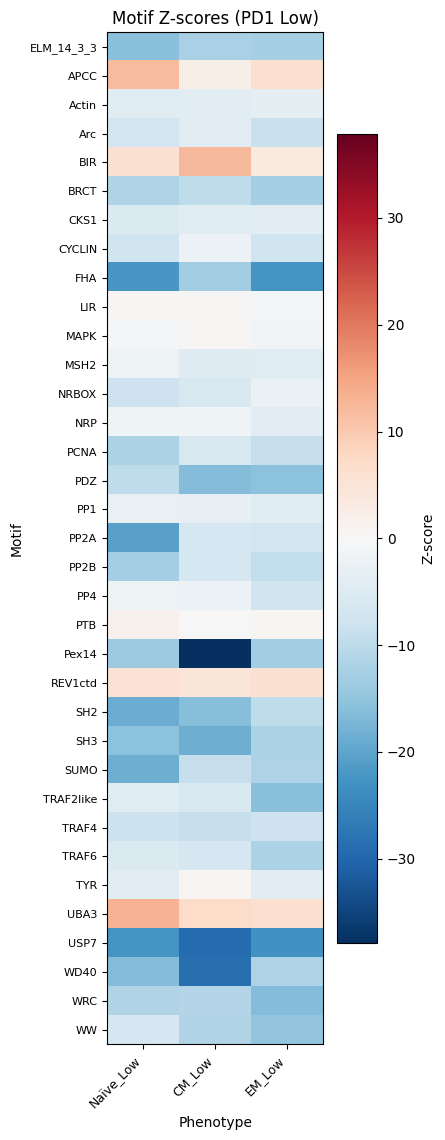

In [13]:
# Volcano plot (now with colors)
fig, ax = cs.volcano_plot(res, title="EM vs CM")

# Heatmap of Z-scores across all phenotypes
fig, ax, data = cs.coef_heatmap(
    fit,
    motifs=motif_cols,
    phenotypes=["Naïve_High", "Naïve_Low", "CM_High", "CM_Low", "EM_High", "EM_Low"],
    value="z",
    title="Motif Z-scores by Phenotype"
)

# Or just the coarse phenotypes with PD1_Low
fig, ax, data = cs.coef_heatmap(
    fit,
    motifs=motif_cols,
    phenotypes=["Naïve_Low", "CM_Low", "EM_Low"],
    value="z",
    title="Motif Z-scores (PD1 Low)"
)

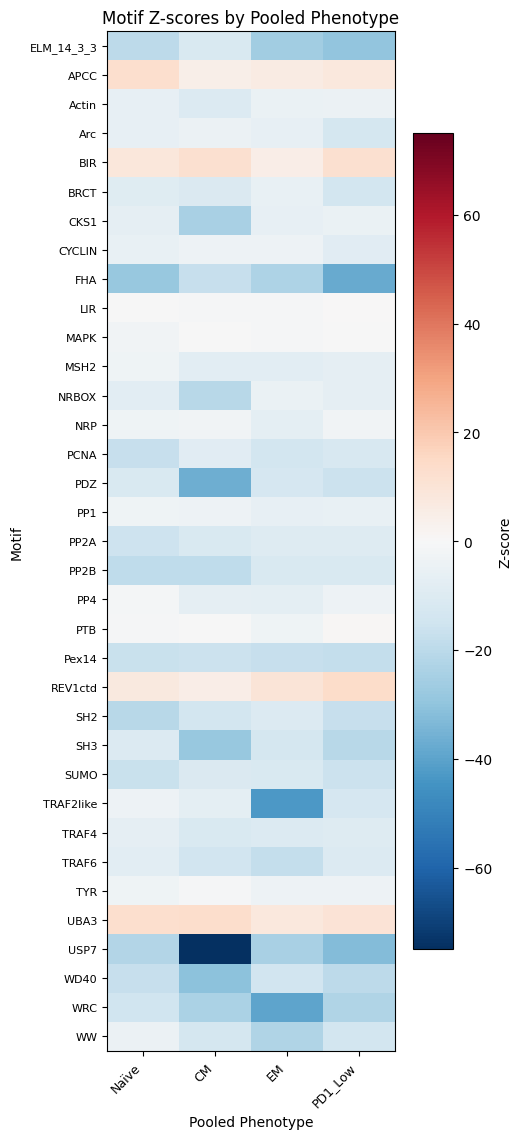

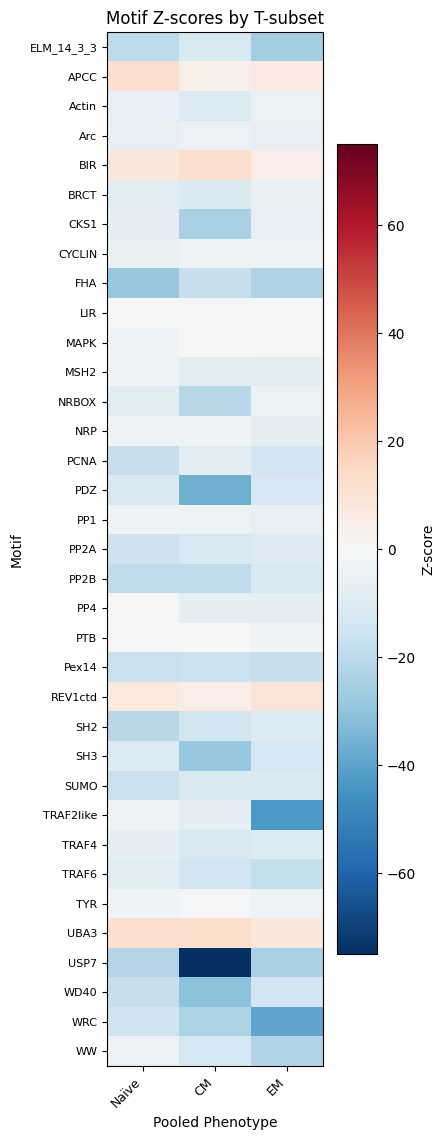

In [14]:
# Heatmap with pooled phenotypes
fig, ax, data = cs.pooled_coef_heatmap(
    fit,
    motifs=motif_cols,
    title="Motif Z-scores by Pooled Phenotype"
)

# Without the PD1_Low column
fig, ax, data = cs.pooled_coef_heatmap(
    fit,
    motifs=motif_cols,
    include_pd1_low=False,
    title="Motif Z-scores by T-subset"
)

In [8]:
phenotypes = list(df_raji["phenotype"].cat.categories)
print("Phenotypes:", phenotypes)

motif = motif_cols[0]
p, q = phenotypes[0], phenotypes[1]
L, cname = cs.motif_diff_between_phenotypes(fit, motif, p, q)
est, pval = cs.wald_contrast(fit, L, cname)
print(cname, est, pval)

Phenotypes: ['CM_High', 'CM_Low', 'EM_High', 'EM_Low', 'Naïve_High', 'Naïve_Low']
ELM_14_3_3: CM_High - CM_Low 0.09721938166570596 6.378116844283883e-35


In [16]:
print("df_raji shape:", df_raji.shape)
print("Number of motif columns:", len(motif_cols))
print("Unique phenotypes:", df_raji["phenotype"].nunique())
print("Unique blocks:", df_raji["block"].nunique())

# Check for low-variance motif columns in df_raji
motif_sums = df_raji[motif_cols].sum()
print("\nMotifs with 0 variance (all zeros):", (motif_sums == 0).sum())
print("Motifs with < 10 total:", (motif_sums < 10).sum())

df_raji shape: (35748, 199)
Number of motif columns: 187
Unique phenotypes: 6
Unique blocks: 6

Motifs with 0 variance (all zeros): 0
Motifs with < 10 total: 0


In [17]:
print("Unique CandidateIDs in df_raji:", df_raji["CandidateID"].nunique())
print("Unique sample_ids in df_raji:", df_raji["sample_id"].nunique())
print("Expected rows:", df_raji["CandidateID"].nunique() * df_raji["sample_id"].nunique())
print("Actual rows:", len(df_raji))

# Check if there are duplicates
print("\nDuplicate (CandidateID, sample_id) pairs:",
        df_raji.duplicated(subset=["CandidateID", "sample_id"]).sum())

# What samples are in the CAR:Raji condition?
print("\nSamples in CAR:Raji:")
print(df_raji["sample_id"].unique())

Unique CandidateIDs in df_raji: 993
Unique sample_ids in df_raji: 36
Expected rows: 35748
Actual rows: 35748

Duplicate (CandidateID, sample_id) pairs: 0

Samples in CAR:Raji:
['1_CAR:Raji_CM_High_1' '1_CAR:Raji_CM_High_2' '1_CAR:Raji_CM_High_3'
 '1_CAR:Raji_CM_Low_1' '1_CAR:Raji_CM_Low_2' '1_CAR:Raji_CM_Low_3'
 '1_CAR:Raji_EM_High_1' '1_CAR:Raji_EM_High_2' '1_CAR:Raji_EM_High_3'
 '1_CAR:Raji_EM_Low_1' '1_CAR:Raji_EM_Low_2' '1_CAR:Raji_EM_Low_3'
 '1_CAR:Raji_Naïve_High_1' '1_CAR:Raji_Naïve_High_2'
 '1_CAR:Raji_Naïve_High_3' '1_CAR:Raji_Naïve_Low_1'
 '1_CAR:Raji_Naïve_Low_2' '1_CAR:Raji_Naïve_Low_3' '2_CAR:Raji_CM_High_1'
 '2_CAR:Raji_CM_High_2' '2_CAR:Raji_CM_High_3' '2_CAR:Raji_CM_Low_1'
 '2_CAR:Raji_CM_Low_2' '2_CAR:Raji_CM_Low_3' '2_CAR:Raji_EM_High_1'
 '2_CAR:Raji_EM_High_2' '2_CAR:Raji_EM_High_3' '2_CAR:Raji_EM_Low_1'
 '2_CAR:Raji_EM_Low_2' '2_CAR:Raji_EM_Low_3' '2_CAR:Raji_Naïve_High_1'
 '2_CAR:Raji_Naïve_High_2' '2_CAR:Raji_Naïve_High_3'
 '2_CAR:Raji_Naïve_Low_1' '2_CAR:Raji_Naï

In [8]:
print("Unique phenotypes:", df_raji["phenotype"].nunique(), df_raji["phenotype"].unique())
print("Unique blocks:", df_raji["block"].nunique(), df_raji["block"].unique()[:10])
print("df_raji shape:", df_raji.shape)

Unique phenotypes: 0 [], Categories (0, object): []
Unique blocks: 0 []
df_raji shape: (0, 199)
